In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from collections import Counter
from scipy.stats import randint
import warnings

warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv(r"/content/hcvdat0.csv")


data.drop([ "Unnamed: 0"], axis=1, inplace=True)
print(data.columns)

data.replace(to_replace=['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis',
       '2=Fibrosis', '3=Cirrhosis'],
             value=[0,1,2,3,4],inplace=True)

data.replace(to_replace=['m','f'],
             value=[0,1],inplace=True)


               #handling missing values of cirrosis
data_cirrhosis=data[data['Category']== 4]
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values = np.nan, strategy ='mean')
si = si.fit(data_cirrhosis.iloc[:,1:13])
data_cirrhosis.iloc[:,1:13]= si.transform(data_cirrhosis.iloc[:,1:13])

               #for blood donor
data_blood_donor=data[data['Category']==0]
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values = np.nan, strategy ='mean')
si = si.fit(data_blood_donor.iloc[:,1:13])
data_blood_donor.iloc[:,1:13]= si.transform(data_blood_donor.iloc[:,1:13])#set_index was not used so needed to start from column 3

               #for heaptitis
data_hepatitis=data[data['Category']==2]
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values = np.nan, strategy ='mean')
si = si.fit(data_hepatitis.iloc[:,1:13])
data_hepatitis.iloc[:,1:13]= si.transform(data_hepatitis.iloc[:,1:13])#set_index was not used so needed to start from column 3

           #for fibrosis
data_Fibrosis=data[data['Category']==3]
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values = np.nan, strategy ='mean')
si = si.fit(data_Fibrosis.iloc[:,1:13])
data_Fibrosis.iloc[:,1:13]= si.transform(data_Fibrosis.iloc[:,1:13])

               #for suspect blood donor
data_suspect=data[data['Category']== 1]

data=pd.concat([data_blood_donor,data_suspect,data_cirrhosis,data_Fibrosis,data_hepatitis])
data.info()

# Assuming data is your dataframe
# First, let's filter only category 0
data_category0 = data[data['Category'] == 0]

# Now, let's detect and replace outliers in each column
new_columns = [ 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

outliers_exist = True
while outliers_exist:
    outliers_exist = False
    for column in new_columns:
        Q1 = data_category0[column].quantile(0.25)
        Q3 = data_category0[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outliers
        outliers = ((data_category0[column] < (Q1 - 1.5 * IQR)) | (data_category0[column] > (Q3 + 1.5 * IQR)))

        if outliers.any():
            outliers_exist = True

            # Replace outliers with the mean of the non-outliers values
            data_category0.loc[outliers, column] = data_category0.loc[~outliers, column].mean()

# Now, replace the original category 0 with the cleaned one
for index in data_category0.index:
    data.loc[index] = data_category0.loc[index]
                                       #now log transform
data['Logged ALT']=np.log(data['ALT'])
data['Logged AST']=np.log(data['AST'])
data['DLogged AST']=np.log(data['Logged AST'])
data['TLogged AST']=np.log(data['DLogged AST']) #Further log transform of AST will result the values to be negative so it will not be logtransformable
data['Logged BIL']=np.log(data['BIL'])
data['Logged GGT']=np.log(data['GGT'])
data['DLogged GGT']=np.log(data['Logged GGT']) #Further log transform of GGT will result the values to be negative so it will not be logtransformable


new_columns=['Age','Sex','ALB','CHE','CHOL','PROT','CREA','ALP','Logged ALT','TLogged AST','Logged BIL','DLogged GGT','Category']
data[new_columns]
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Set the style to white
sns.set_style("whitegrid")
data.drop(['ALT'], axis=1,inplace=True)
data.drop(['AST'], axis=1,inplace=True)
data.drop(['Logged AST'], axis=1,inplace=True)
data.drop(['DLogged AST'], axis=1,inplace=True)
data.drop(['BIL'], axis=1,inplace=True)
data.drop(['GGT'], axis=1,inplace=True)
data.drop(['Logged GGT'], axis=1,inplace=True)

data

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 563
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    int64  
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    int64  
 3   ALB       615 non-null    float64
 4   ALP       615 non-null    float64
 5   ALT       615 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      615 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      615 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 67.3 KB


,Category,Age,Sex,ALB,ALP,CHE,CHOL,CREA,PROT,Logged ALT,TLogged AST,Logged BIL,DLogged GGT
0,0,32.0,0,38.5,52.5,6.93,3.23,106.0,69.0,2.041220,0.122195,2.014903,0.913569
1,0,32.0,0,38.5,70.3,11.17,4.80,74.0,76.5,2.890372,0.152957,1.360977,1.010608
2,0,32.0,0,46.9,74.7,8.84,5.20,86.0,79.3,3.589059,0.157870,1.808289,1.083867
3,0,32.0,0,43.2,52.0,7.33,4.74,80.0,75.7,3.421000,0.128548,1.989637,1.085703
4,0,32.0,0,39.2,74.1,9.15,4.32,76.0,68.7,3.484312,0.154037,2.261763,1.223145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2,58.0,0,43.0,99.1,5.95,6.15,147.3,65.6,2.501436,0.352217,2.564949,1.823976
560,2,33.0,1,43.0,29.6,6.88,5.72,58.8,78.2,1.335001,0.034505,1.791759,0.892959
561,2,41.0,1,37.0,31.2,7.08,5.30,60.8,82.4,2.104134,0.257336,1.945910,1.165275
562,2,50.0,1,40.0,32.7,7.51,4.67,56.6,70.1,2.197225,0.294541,2.302585,1.132881


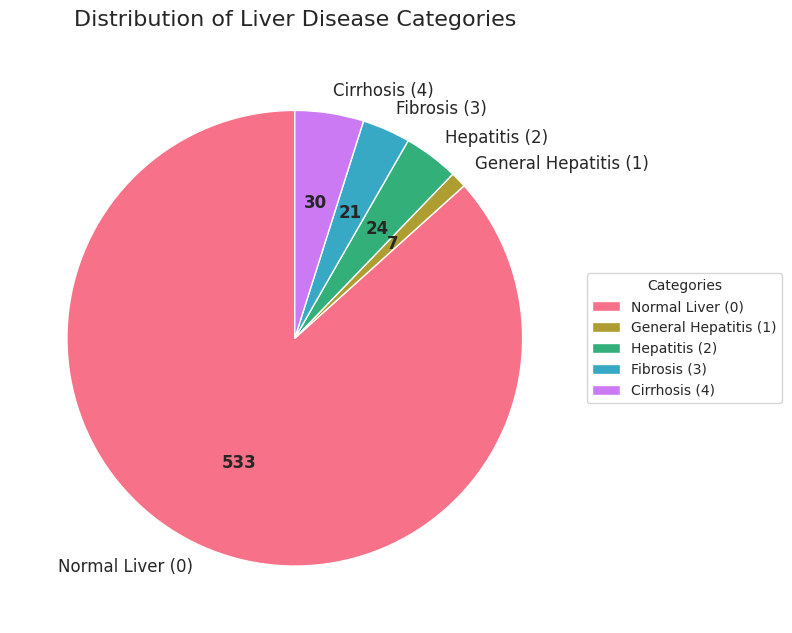

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples in each category (now properly encoded)
category_counts = data['Category'].value_counts().sort_index()

# Define labels with correct numerical mapping
labels = [
    'Normal Liver (0)',
    'General Hepatitis (1)',
    'Hepatitis (2)',
    'Fibrosis (3)',
    'Cirrhosis (4)'
]

# Function to show raw counts
def absolute_value(val):
    total = sum(category_counts)
    count = int(round(val * total / 100))
    return f'{count}'

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    category_counts,
    labels=labels,
    autopct=absolute_value,
    startangle=90,
    colors=sns.color_palette("husl", 5),  # More distinct colors
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 12}
)

# Improve label visibility
plt.setp(autotexts, size=12, weight='bold')
plt.setp(texts, size=12)

# Add a legend for clarity
plt.legend(
    wedges,
    labels,
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Distribution of Liver Disease Categories', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

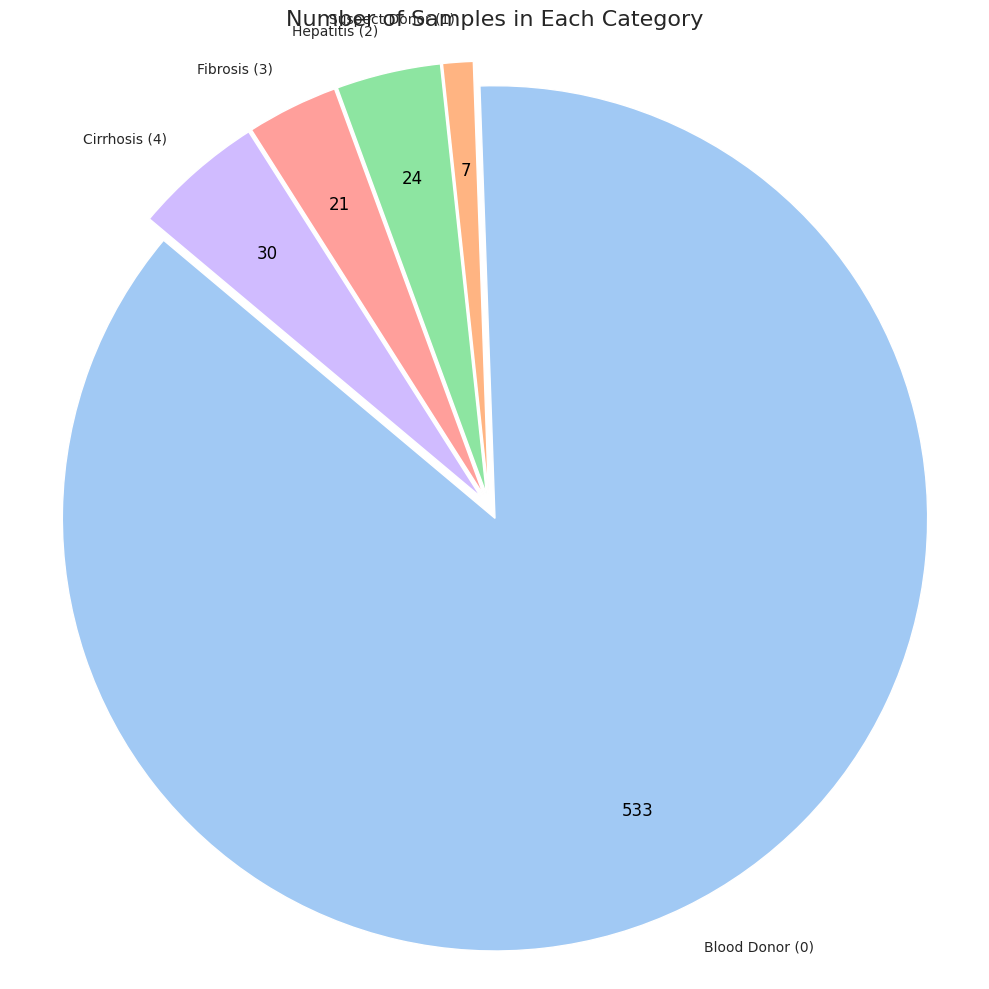

In [6]:
import matplotlib.pyplot as plt

# Count the number of samples in each category
category_counts = data['Category'].value_counts().sort_index()
labels = ['Blood Donor (0)', 'Suspect Donor (1)', 'Hepatitis (2)', 'Fibrosis (3)', 'Cirrhosis (4)']

# Function to show raw counts instead of percentages
def absolute_value(val):
    total = sum(category_counts)
    count = int(round(val * total / 100))
    return f'{count}'

# Small gap between slices
explode = [0.03] * len(labels)

# Plot pie chart
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(
    category_counts,
    labels=labels,
    explode=explode,
    autopct=absolute_value,
    startangle=140,
    colors=sns.color_palette("pastel"),
    labeldistance=1.1,          # Push labels further out
    pctdistance=0.75            # Push value labels slightly in
)

# Styling text
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Number of Samples in Each Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()


In [7]:
# Count the number of samples in each category
category_counts = data['Category'].value_counts().sort_index()

# Define category labels
labels = {
    0: 'Blood Donor',
    1: 'Suspect Blood Donor',
    2: 'Hepatitis',
    3: 'Fibrosis',
    4: 'Cirrhosis'
}

# Print the results in text format
print("Number of Samples in Each Category:\n")
for category, count in category_counts.items():
    print(f"{labels[category]} ({category}): {count} samples")


Number of Samples in Each Category:

Blood Donor (0): 533 samples
Suspect Blood Donor (1): 7 samples
Hepatitis (2): 24 samples
Fibrosis (3): 21 samples
Cirrhosis (4): 30 samples


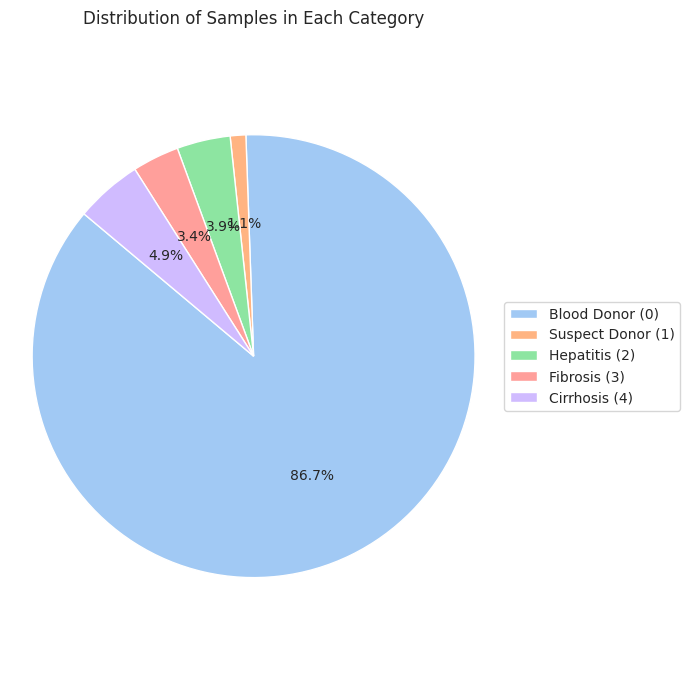

In [8]:
import matplotlib.pyplot as plt

# Count the number of samples in each category
category_counts = data['Category'].value_counts().sort_index()

# Define labels
labels = ['Blood Donor (0)', 'Suspect Donor (1)', 'Hepatitis (2)', 'Fibrosis (3)', 'Cirrhosis (4)']

# Plot pie chart
plt.figure(figsize=(7, 7))
patches, texts, autotexts = plt.pie(
    category_counts,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel")
)

# Add legend outside
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution of Samples in Each Category')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [9]:
!pip install -q scikit-learn
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif # Import SelectKBest and f_classif
X=data.drop(columns=['Category'],axis=1)
y=data['Category']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X, y)

# F-scores and p-values
f_scores = fit.scores_
p_values = fit.pvalues_

# Create DataFrames for scores and p-values
dfscores = pd.DataFrame({'F-score': f_scores, 'p-value': p_values})
dfcolumns = pd.DataFrame(X.columns)

# Combine DataFrames
scorefeature = pd.concat([dfcolumns, dfscores], axis=1)
scorefeature.columns = ['specs', 'F-score', 'p-value']

# Display top 12 features based on F-score
top_features = scorefeature.nlargest(12, 'F-score')
print(top_features)


          specs     F-score       p-value
9   TLogged AST  164.683024  1.585421e-95
10   Logged BIL  144.831239  5.417167e-87
11  DLogged GGT  133.944251  4.542415e-82
2           ALB   69.390666  2.036520e-48
4           CHE   44.959085  4.213372e-33
7          PROT   36.281990  3.196749e-27
3           ALP   31.173246  1.218003e-23
8    Logged ALT   25.730177  1.003550e-19
5          CHOL   19.526131  3.914646e-15
0           Age   11.694165  3.712404e-09
6          CREA   11.403133  6.236281e-09
1           Sex    1.918366  1.057726e-01


In [10]:
X_train = data.drop(['Category', 'Sex', 'CREA'], axis=1)
y_train = data['Category']


In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)


In [12]:
# prompt: now show the no of samples in each class after smote

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Count the number of samples in each class after SMOTE
from collections import Counter
print(f"Number of samples in each class after SMOTE: {Counter(y_train_resampled)}")


Number of samples in each class after SMOTE: Counter({0: 533, 1: 533, 4: 533, 3: 533, 2: 533})


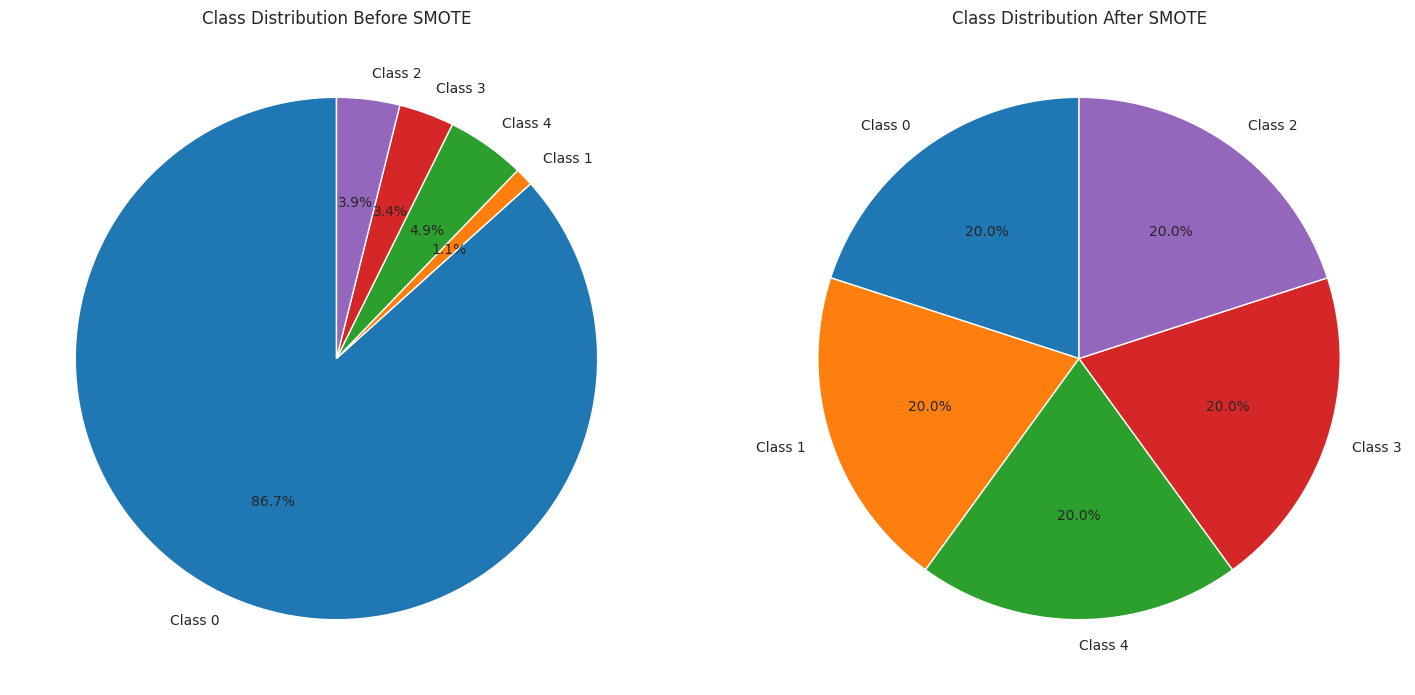

In [13]:
# prompt: now generate a pie chart showing the distribution in each category befor smote and after smote display the charts side by side and in a clear representation

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming X_train and y_train are defined as in the provided code
# ... (your existing code for data preprocessing and SMOTE) ...


# Original class distribution
original_counts = Counter(y_train)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart for original data
labels = [f'Class {i}' for i in original_counts.keys()]
axes[0].pie(original_counts.values(), labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution Before SMOTE')


# Pie chart for SMOTE-resampled data
smote_counts = Counter(y_train_resampled)
labels = [f'Class {i}' for i in smote_counts.keys()]
axes[1].pie(smote_counts.values(), labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution After SMOTE')


# Improve chart layout
plt.tight_layout()
plt.show()


In [14]:
# ipython-input-16-c28a2b283be8

# Get column names from the original data (excluding the dropped columns)
column_names = data.drop(['Category', 'Sex', 'CREA'], axis=1).columns.tolist()

# Assuming X_train_resampled and y_train_resampled from SMOTE are available
# Convert the resampled data into DataFrames
X_resampled = pd.DataFrame(X_train_resampled, columns=column_names)  # Use X_train_resampled from SMOTE
y_resampled = pd.Series(y_train_resampled)  # Use y_train_resampled from SMOTE

In [15]:
num_samples_per_category = 150
test_indices = []

for category in np.unique(y_resampled):
    category_indices = np.where(y_resampled == category)[0]
    category_indices = category_indices[:num_samples_per_category]
    test_indices.extend(category_indices)


In [16]:
new_test_indices = []
for index in test_indices:
    new_test_indices.append(X_resampled.index[index])

X_test = X_resampled.loc[new_test_indices]
y_test = y_resampled[new_test_indices]


In [17]:
X_train = X_resampled.drop(index=new_test_indices)
y_train = y_resampled.drop(index=new_test_indices)


In [18]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9933333333333333


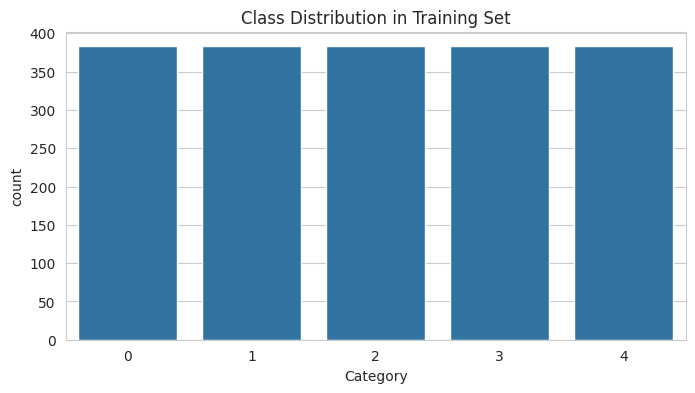

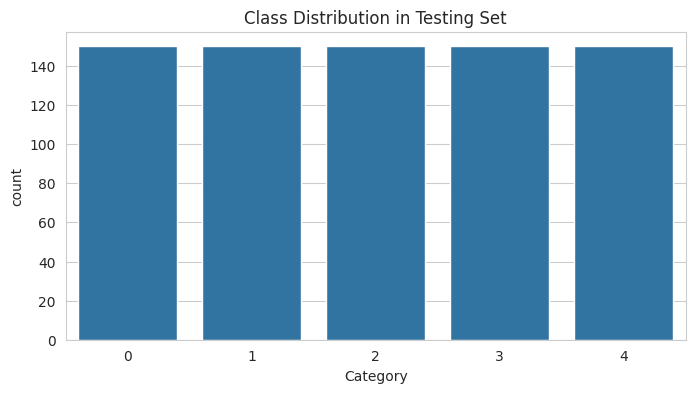

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x=y_test)
plt.title("Class Distribution in Testing Set")
plt.show()


In [20]:
from sklearn.svm import SVC
svm = SVC()

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
xg = XGBClassifier()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

xg.fit(X_train, y_train)
dt.fit(X_train, y_train)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

# Define base models
rf = RandomForestClassifier()
svm = SVC(probability=True)  # Stacking needs probability=True
xg = XGBClassifier()
dt = DecisionTreeClassifier()

# List of base estimators
estimator_list = [
    ('rf', rf),
    ('svm', svm),
    ('xg', xg),
    ('dt', dt)
]

# Define the Stacking Classifier
stack_model = StackingClassifier(
    estimators=estimator_list,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# Define a smaller hyperparameter grid for the meta-classifier (Logistic Regression)
final_estimator_params = {
    'final_estimator__penalty': ['l2'],
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__solver': ['lbfgs'],
    'final_estimator__max_iter': [100, 250]
}

# RandomizedSearchCV for tuning
final_estimator_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=final_estimator_params,
    n_iter=10,                 # Try 10 random combinations
    cv=5,                      # 5-fold CV
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model
final_estimator_search.fit(X_train, y_train)

# Print best results
print({
    'model': 'logistic_regression (stacking meta-learner)',
    'best_score': final_estimator_search.best_score_,
    'best_params': final_estimator_search.best_params_
})


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model': 'logistic_regression (stacking meta-learner)', 'best_score': np.float64(0.989556135770235), 'best_params': {'final_estimator__solver': 'lbfgs', 'final_estimator__penalty': 'l2', 'final_estimator__max_iter': 250, 'final_estimator__C': 10}}


In [23]:
solver = 'sag'
penalty = None  # Change 'none' to None
max_iterations = 500
c_value = 0.0001
stack_model2 = StackingClassifier(
    estimators=estimator_list,
    final_estimator=LogisticRegression(solver=solver, penalty=penalty, max_iter=max_iterations, C=c_value)

)
stack_model2.fit(X_train, y_train)
stack_pred2 = stack_model2.predict(X_test)
print(f"random forest test Accuracy : {accuracy_score(y_test, stack_pred2)}")
from sklearn.metrics import precision_score, recall_score

precision_micro = precision_score(y_test, stack_pred2, average='micro')
recall_micro = recall_score(y_test, stack_pred2, average='micro')

precision_macro = precision_score(y_test, stack_pred2, average='macro')
recall_macro = recall_score(y_test, stack_pred2, average='macro')
print(f"test Accuracy : {accuracy_score(y_test, stack_pred2)}")
print(f"Micro-average Precision: {precision_micro}")
print(f"Micro-average Recall: {recall_micro}")
print(f"Macro-average Precision: {precision_macro}")
print(f"Macro-average Recall: {recall_macro}")
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, stack_pred2)
rmse = np.sqrt(mean_squared_error(y_test, stack_pred2))  # Calculate RMSE by taking the square root of MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

random forest test Accuracy : 0.9986666666666667
test Accuracy : 0.9986666666666667
Micro-average Precision: 0.9986666666666667
Micro-average Recall: 0.9986666666666667
Macro-average Precision: 0.9986754966887418
Macro-average Recall: 0.9986666666666666
Mean Absolute Error (MAE): 0.004
Root Mean Squared Error (RMSE): 0.10954451150103323


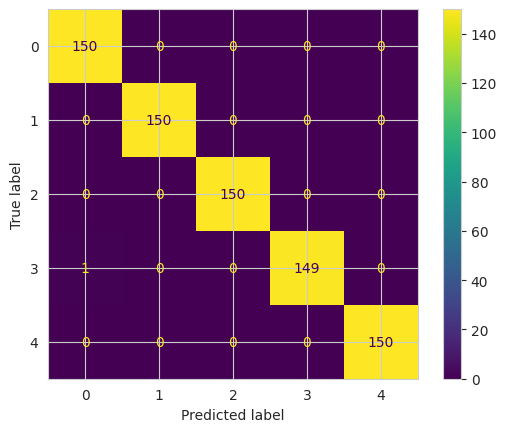

In [24]:
# prompt: generate confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming stack_pred2 and y_test are defined from previous code
cm = confusion_matrix(y_test, stack_pred2)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [25]:
# prompt: generate code to save the model and its weights

import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
# ... (your existing code) ...

# Save the trained StackingClassifier model
filename = 'stacking_model.sav'
pickle.dump(stack_model2, open(filename, 'wb'))

#To load the model use this code
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)


In [26]:
# prompt: generate the code to save the weights used in this training process

import pickle

# ... (your existing code) ...

# Save the trained StackingClassifier model
filename = 'stacking_model.sav'
pickle.dump(stack_model2, open(filename, 'wb'))


In [27]:
# prompt:  me the scaler.sav file – the fitted StandardScaler object used during model training

import pickle

# Assuming 'ss' is your fitted StandardScaler object
# from your previous code.

# Save the scaler object
filename = 'scaler.sav'
pickle.dump(ss, open(filename, 'wb'))


In [28]:
# prompt: now generate apply these models individually and note down each metrics

import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             mean_absolute_error, mean_squared_error,
                             precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ... (Your existing code) ...


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  print(f"--- {model_name} ---")
  print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")
  print(f"Test Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"MAE: {mae}")
  print(f"RMSE: {rmse}")
  print("-" * 20)
  return {
      'model': model_name,
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'mae': mae,
      'rmse': rmse,
  }


models = [
    (SVC(), "SVM"),
    (XGBClassifier(), "XGBoost"),
    (RandomForestClassifier(), "Random Forest"),
    (DecisionTreeClassifier(), "Decision Tree"),


]

results = []
for model, model_name in models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    results.append(result)

# Evaluate the stacking model
results.append(evaluate_model(stack_model, X_train, y_train, X_test, y_test, "Stacking Classifier"))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df


--- SVM ---
Train Accuracy: 0.9953002610966057
Test Accuracy: 0.9906666666666667
Precision: 0.9908445734406884
Recall: 0.9906666666666666
F1-score: 0.9906422006152326
MAE: 0.017333333333333333
RMSE: 0.18257418583505536
--------------------
--- XGBoost ---
Train Accuracy: 1.0
Test Accuracy: 0.9933333333333333
Precision: 0.9933767769163377
Recall: 0.9933333333333334
F1-score: 0.9933330814707814
MAE: 0.014666666666666666
RMSE: 0.18257418583505536
--------------------
--- Random Forest ---
Train Accuracy: 1.0
Test Accuracy: 0.9973333333333333
Precision: 0.9973684210526315
Recall: 0.9973333333333333
F1-score: 0.9973332148095471
MAE: 0.005333333333333333
RMSE: 0.10327955589886445
--------------------
--- Decision Tree ---
Train Accuracy: 1.0
Test Accuracy: 0.9613333333333334
Precision: 0.9613717935432818
Recall: 0.9613333333333334
F1-score: 0.9613229026494938
MAE: 0.07866666666666666
RMSE: 0.43969686527576396
--------------------
--- Stacking Classifier ---
Train Accuracy: 1.0
Test Accuracy:

,model,accuracy,precision,recall,f1,mae,rmse
0,SVM,0.990667,0.990845,0.990667,0.990642,0.017333,0.182574
1,XGBoost,0.993333,0.993377,0.993333,0.993333,0.014667,0.182574
2,Random Forest,0.997333,0.997368,0.997333,0.997333,0.005333,0.103280
3,Decision Tree,0.961333,0.961372,0.961333,0.961323,0.078667,0.439697
4,Stacking Classifier,0.997333,0.997368,0.997333,0.997333,0.005333,0.103280


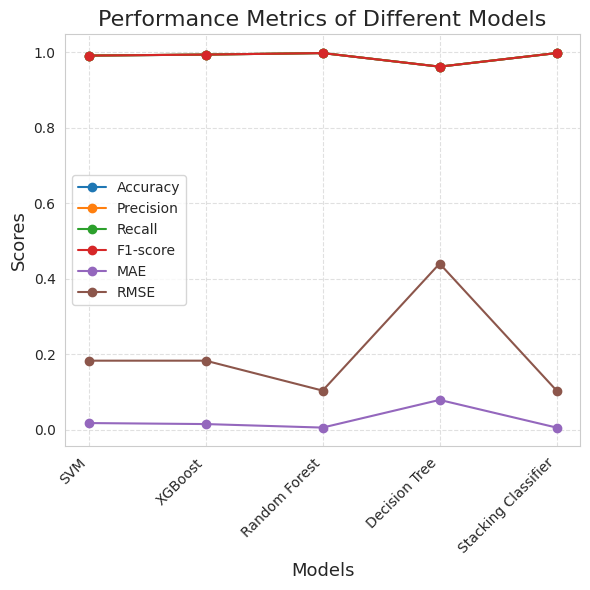

In [29]:
import matplotlib.pyplot as plt

# Assuming 'results_df' exists and contains performance metrics for each model
# Columns: ['model', 'accuracy', 'precision', 'recall', 'f1', 'mae', 'rmse']

# Extract data
models = results_df['model'].tolist()
accuracy = results_df['accuracy'].tolist()
precision = results_df['precision'].tolist()
recall = results_df['recall'].tolist()
f1 = results_df['f1'].tolist()
mae = results_df['mae'].tolist()
rmse = results_df['rmse'].tolist()

# Plot
plt.figure(figsize=(6, 6))
plt.plot(models, accuracy, label='Accuracy', marker='o')
plt.plot(models, precision, label='Precision', marker='o')
plt.plot(models, recall, label='Recall', marker='o')
plt.plot(models, f1, label='F1-score', marker='o')
plt.plot(models, mae, label='MAE', marker='o')
plt.plot(models, rmse, label='RMSE', marker='o')

# Styling
plt.title('Performance Metrics of Different Models', fontsize=16)
plt.xlabel('Models', fontsize=13)
plt.ylabel('Scores', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


ExactExplainer explainer: 11it [00:10,  5.23s/it]


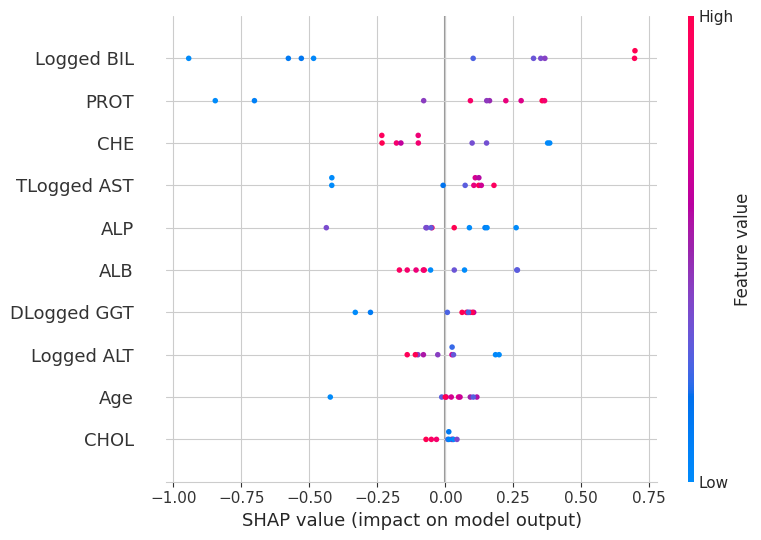

In [30]:
import shap

# Smaller sample
X_sample = X_test.sample(10, random_state=42)

# KernelExplainer (generic for any model)
explainer = shap.Explainer(stack_model.predict, X_sample)
shap_values = explainer(X_sample)

# Plot
shap.summary_plot(shap_values, X_sample)


🔎 Waterfall Plot for Instance 0


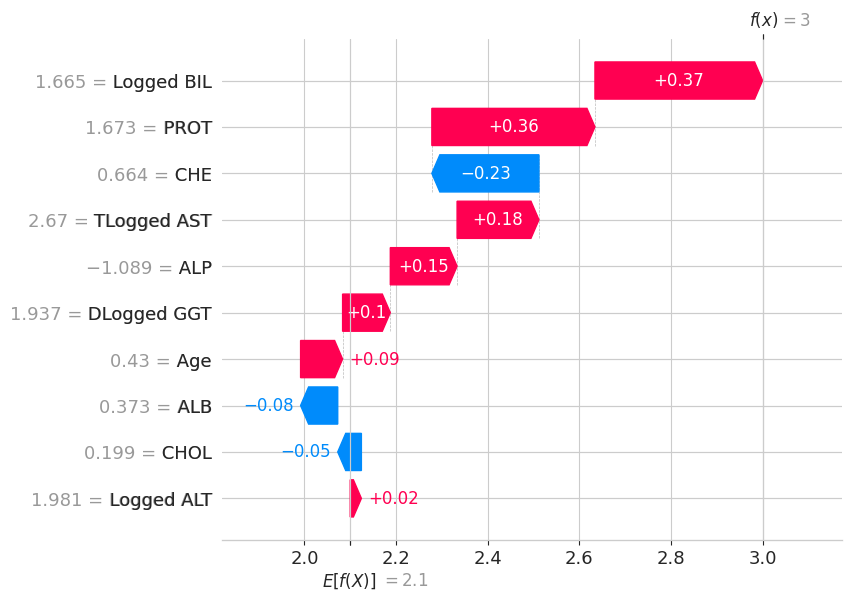


🔍 Top Feature (Globally): Logged BIL


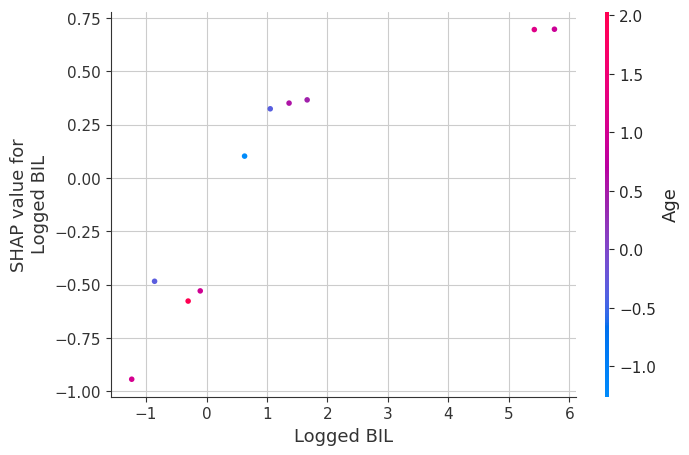

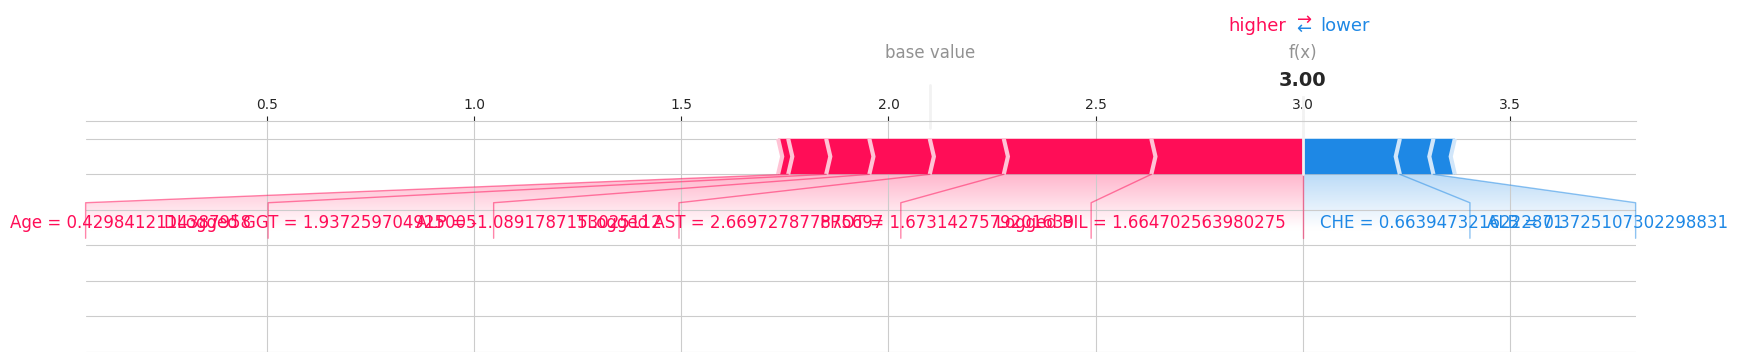


📌 Top 5 Features per Prediction:
Instance 0: ['Logged BIL', 'PROT', 'CHE', 'TLogged AST', 'ALP']
Instance 1: ['Age', 'PROT', 'ALB', 'Logged BIL', 'CHE']
Instance 2: ['Logged BIL', 'ALP', 'TLogged AST', 'DLogged GGT', 'CHE']
Instance 3: ['Logged BIL', 'TLogged AST', 'Logged ALT', 'CHE', 'PROT']
Instance 4: ['PROT', 'Logged BIL', 'Logged ALT', 'TLogged AST', 'CHE']
Instance 5: ['Logged BIL', 'CHE', 'ALB', 'Logged ALT', 'PROT']
Instance 6: ['TLogged AST', 'Logged BIL', 'DLogged GGT', 'ALP', 'PROT']
Instance 7: ['PROT', 'Logged BIL', 'CHE', 'DLogged GGT', 'TLogged AST']
Instance 8: ['Logged BIL', 'PROT', 'CHE', 'ALP', 'Age']
Instance 9: ['Logged BIL', 'CHE', 'ALB', 'Logged ALT', 'PROT']


In [31]:
# Install SHAP
!pip install shap -q

# Imports
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Sample a few rows for faster SHAP computation
X_sample = X_test.sample(10, random_state=42)

# Create SHAP explainer using the model's predict function
explainer = shap.Explainer(stack_model.predict, X_sample)

# Compute SHAP values
shap_values = explainer(X_sample)

# --------- 📌 Pick an instance to explain ---------
index_of_instance = 0
instance = X_sample.iloc[index_of_instance]

# --------- 📊 Waterfall Plot ---------
print("🔎 Waterfall Plot for Instance", index_of_instance)
shap.plots.waterfall(shap_values[index_of_instance])

# --------- ⭐ Top Feature by Global Impact ---------
shap_df = pd.DataFrame(shap_values.values, columns=X_sample.columns)
mean_shap = shap_df.abs().mean().sort_values(ascending=False)
top_feature = mean_shap.index[0]
print(f"\n🔍 Top Feature (Globally): {top_feature}")

# --------- 📈 Dependence Plot for Top Feature ---------
shap.dependence_plot(top_feature, shap_values.values, X_sample)

# --------- ⚡ Force Plot ---------
shap.initjs()

# Get base value for force plot
base_value = shap_values.base_values[index_of_instance]
shap.force_plot(base_value, shap_values[index_of_instance].values, instance, matplotlib=True)

# --------- 📋 Top 5 Features for Each Prediction ---------
print("\n📌 Top 5 Features per Prediction:")
for i in range(len(X_sample)):
    sorted_indices = abs(shap_values[i].values).argsort()[::-1][:5]
    top_features = X_sample.columns[sorted_indices].tolist()
    print(f"Instance {i}: {top_features}")


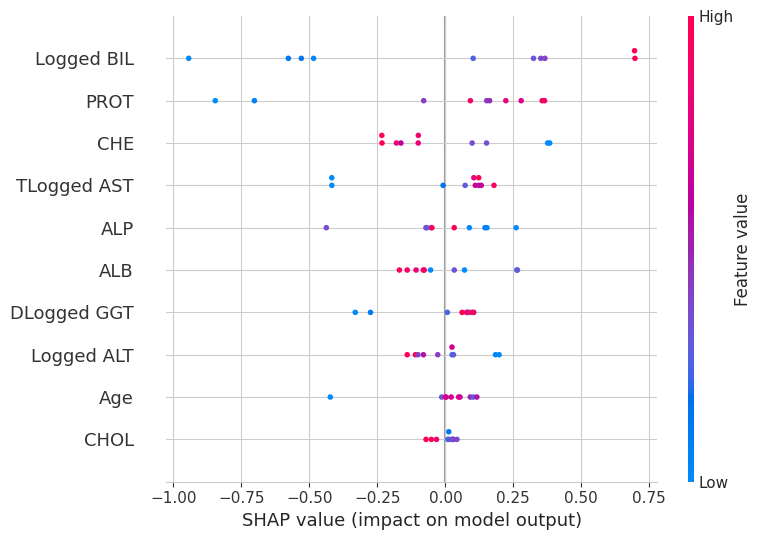

In [32]:
shap.summary_plot(shap_values, X_sample)


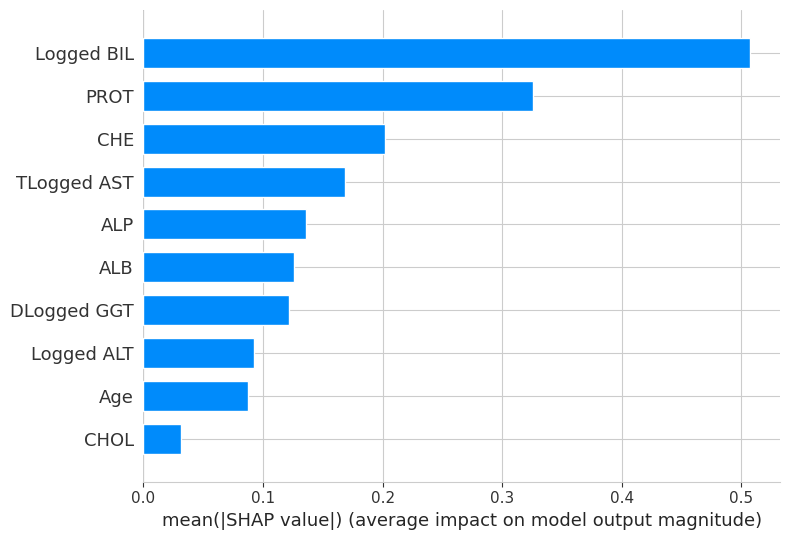

In [33]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")
